#  Statistical Downscaling and Bias-Adjustment

`xsdba` provides tools and utilities to ease the bias-adjustment process. Almost all adjustment algorithms conform to the `train` - `adjust` scheme, formalized within `TrainAdjust` classes. Given a reference time series (`ref`), historical simulations (`hist`) and simulations to be adjusted (`sim`), any bias-adjustment method would be applied by first estimating the adjustment factors between the historical simulation and the observation series, and then applying these factors to `sim`, which could be a future simulation.

This presents examples, while a bit more info and the API are given on [this page](../xsdba.rst).

A very simple "Quantile Mapping" approach is available through the `EmpiricalQuantileMapping` object. The object is created through the `.train` method of the class, and the simulation is adjusted with `.adjust`.

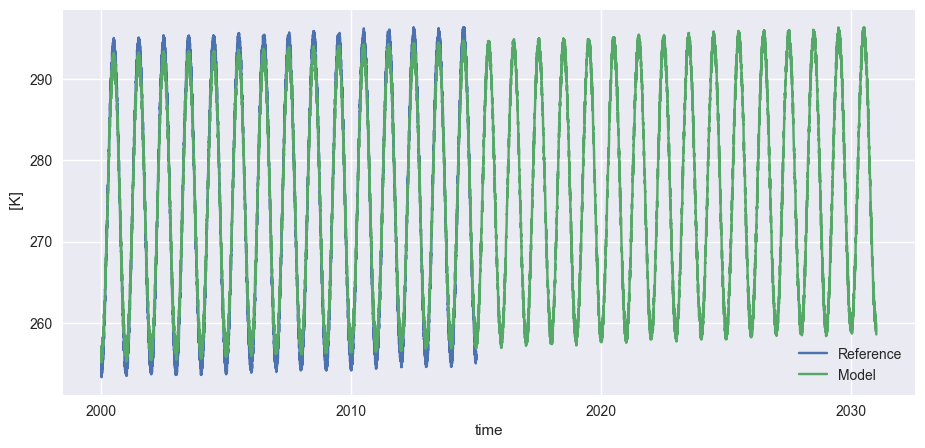

In [1]:
from __future__ import annotations

import cftime  # noqa
import matplotlib.pyplot as plt
import nc_time_axis  # noqa
import numpy as np
import xarray as xr

%matplotlib inline
plt.style.use("seaborn-v0_8")
plt.rcParams["figure.figsize"] = (11, 5)

# Create toy data to explore bias adjustment, here fake temperature timeseries
t = xr.cftime_range("2000-01-01", "2030-12-31", freq="D", calendar="noleap")

ref = xr.DataArray(
    (
        -20 * np.cos(2 * np.pi * t.dayofyear / 365)
        + 2 * np.random.random_sample((t.size,))
        + 273.15
        + 0.1 * (t - t[0]).days / 365
    ),  # "warming" of 1K per decade,
    dims=("time",),
    coords={"time": t},
    attrs={"units": "K"},
)
sim = xr.DataArray(
    (
        -18 * np.cos(2 * np.pi * t.dayofyear / 365)
        + 2 * np.random.random_sample((t.size,))
        + 273.15
        + 0.11 * (t - t[0]).days / 365
    ),  # "warming" of 1.1K per decade
    dims=("time",),
    coords={"time": t},
    attrs={"units": "K"},
)

ref = ref.sel(time=slice(None, "2015-01-01"))
hist = sim.sel(time=slice(None, "2015-01-01"))

ref.plot(label="Reference")
sim.plot(label="Model")
plt.legend()

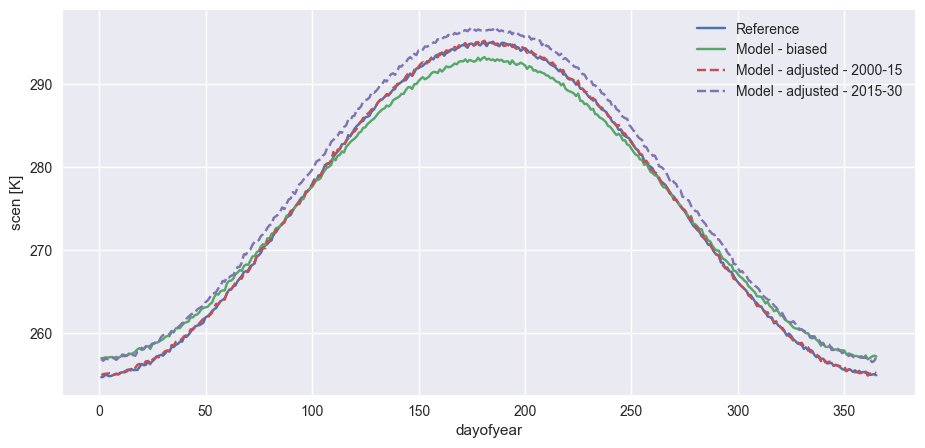

In [2]:
import xsdba 

QM = xsdba.EmpiricalQuantileMapping.train(
    ref, hist, nquantiles=15, group="time", kind="+"
)
scen = QM.adjust(sim, extrapolation="constant", interp="nearest")

ref.groupby("time.dayofyear").mean().plot(label="Reference")
hist.groupby("time.dayofyear").mean().plot(label="Model - biased")
scen.sel(time=slice("2000", "2015")).groupby("time.dayofyear").mean().plot(
    label="Model - adjusted - 2000-15", linestyle="--"
)
scen.sel(time=slice("2015", "2030")).groupby("time.dayofyear").mean().plot(
    label="Model - adjusted - 2015-30", linestyle="--"
)
plt.legend()

In the previous example, a simple Quantile Mapping algorithm was used with 15 quantiles and one group of values. The model performs well, but our toy data is also quite smooth and well-behaved so this is not surprising.

A more complex example could have bias distribution varying strongly across months. To perform the adjustment with different factors for each month, one can pass `group='time.month'`. Moreover, to reduce the risk of drastic changes in the adjustments at the interface of months, `interp='linear'` can be passed to `.adjust` and the adjustment factors will be interpolated linearly (e.g.: the factors for the 1st of May will be the average of those for both April and May).

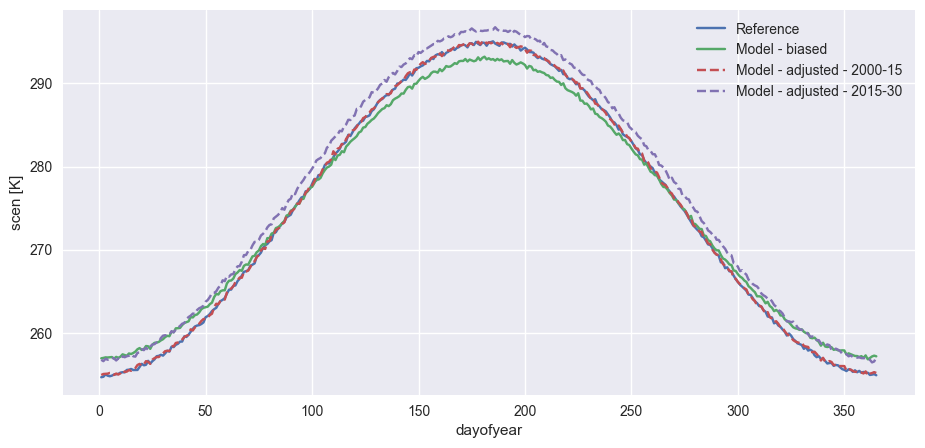

In [3]:
QM_mo = xsdba.EmpiricalQuantileMapping.train(
    ref, hist, nquantiles=15, group="time.month", kind="+"
)
scen = QM_mo.adjust(sim, extrapolation="constant", interp="linear")

ref.groupby("time.dayofyear").mean().plot(label="Reference")
hist.groupby("time.dayofyear").mean().plot(label="Model - biased")
scen.sel(time=slice("2000", "2015")).groupby("time.dayofyear").mean().plot(
    label="Model - adjusted - 2000-15", linestyle="--"
)
scen.sel(time=slice("2015", "2030")).groupby("time.dayofyear").mean().plot(
    label="Model - adjusted - 2015-30", linestyle="--"
)
plt.legend()

The training data (here the adjustment factors) is available for inspection in the `ds` attribute of the adjustment object.

In [4]:
QM_mo.ds

<xarray.Dataset> Size: 3kB
Dimensions:    (month: 12, quantiles: 15)
Coordinates:
  * quantiles  (quantiles) float64 120B 0.03333 0.1 0.1667 ... 0.8333 0.9 0.9667
  * month      (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    af         (month, quantiles) float64 1kB -1.996 -2.002 ... -1.88 -1.834
    hist_q     (month, quantiles) float64 1kB 256.0 256.4 256.7 ... 259.2 259.8
Attributes:
    group:               time.month
    group_compute_dims:  ['time']
    group_window:        1
    _xsdba_adjustment:   {"py/object": "xsdba.adjustment.EmpiricalQuantileMap...
    adj_params:          EmpiricalQuantileMapping(group=Grouper(name='time.mo...

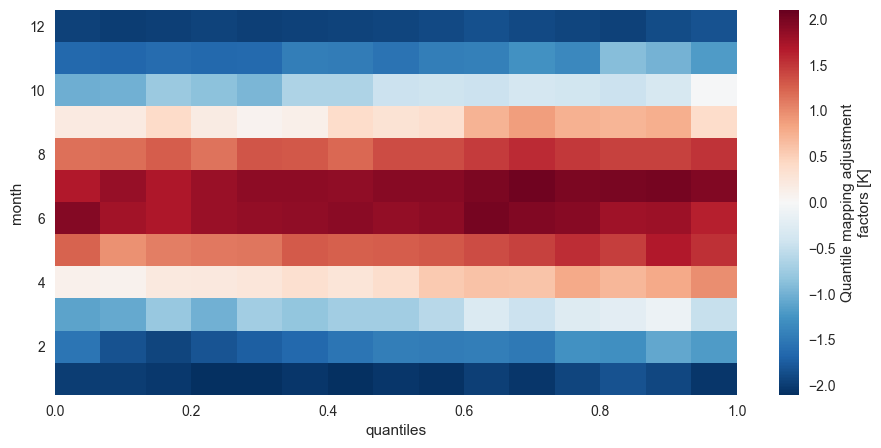

In [5]:
QM_mo.ds.af.plot()

## Grouping

For basic time period grouping (months, day of year, season), passing a string to the methods needing it is sufficient. Most methods acting on grouped data also accept a `window` int argument to pad the groups with data from adjacent ones. Units of `window` are the sampling frequency of the main grouping dimension (usually `time`). For more complex grouping, or simply for clarity, one can pass a `xsdba.base.Grouper` directly.

Another example of a simpler, adjustment method is below; Here we want `sim` to be scaled so that its mean fits the one of `ref`. Scaling factors are to be computed separately for each day of the year, but including 15 days on either side of the day. This means that the factor for the 1st of May is computed including all values from the 16th of April to the 15th of May (of all years).

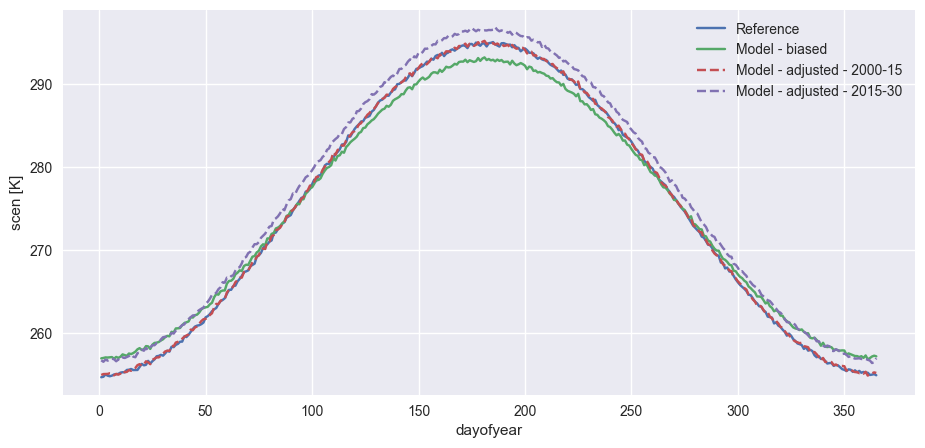

In [6]:
group = xsdba.Grouper("time.dayofyear", window=31)
QM_doy = xsdba.Scaling.train(ref, hist, group=group, kind="+")
scen = QM_doy.adjust(sim)

ref.groupby("time.dayofyear").mean().plot(label="Reference")
hist.groupby("time.dayofyear").mean().plot(label="Model - biased")
scen.sel(time=slice("2000", "2015")).groupby("time.dayofyear").mean().plot(
    label="Model - adjusted - 2000-15", linestyle="--"
)
scen.sel(time=slice("2015", "2030")).groupby("time.dayofyear").mean().plot(
    label="Model - adjusted - 2015-30", linestyle="--"
)
plt.legend()

In [7]:
sim

<xarray.DataArray (time: 11315)> Size: 91kB
array([256.609732, 256.438077, 255.200139, ..., 258.855989, 258.750659,
       258.624197])
Coordinates:
  * time     (time) object 91kB 2000-01-01 00:00:00 ... 2030-12-31 00:00:00
Attributes:
    units:    K

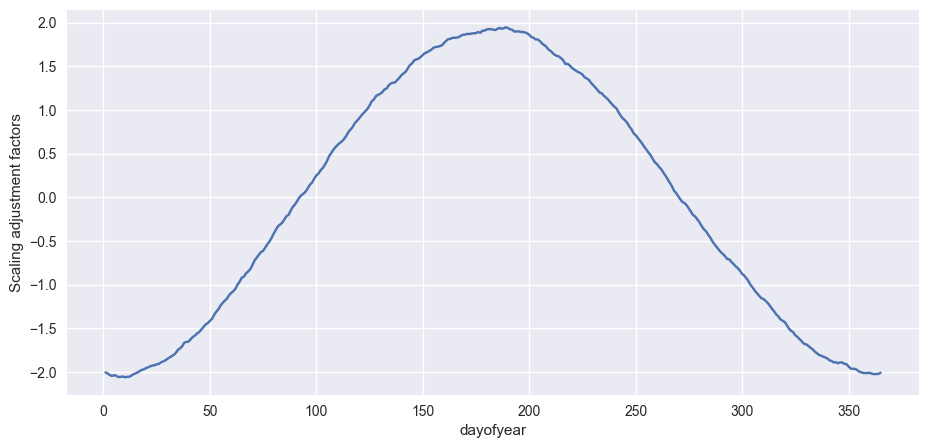

In [8]:
QM_doy.ds.af.plot()

## Modular approach

The `xsdba` module adopts a modular approach instead of implementing published and named methods directly.
A generic bias adjustment process is laid out as follows:

- preprocessing on `ref`, `hist` and `sim` (using methods in `xsdba.processing` or `xsdba.detrending`)
- creating and training the adjustment object `Adj = Adjustment.train(obs, hist, **kwargs)` (from `xsdba.adjustment`)
- adjustment `scen = Adj.adjust(sim, **kwargs)`
- post-processing on `scen` (for example: re-trending)

The train-adjust approach allows us to inspect the trained adjustment object. The training information is stored in the underlying `Adj.ds` dataset and often has a `af` variable with the adjustment factors. Its layout and the other available variables vary between the different algorithm, refer to their part of the API docs.

For heavy processing, this separation allows the computation and writing to disk of the training dataset before performing the adjustment(s). See the [advanced notebook](advanced_example.ipynb).

Parameters needed by the training and the adjustment are saved to the `Adj.ds` dataset as a  `adj_params` attribute. For other parameters, those only needed by the adjustment are passed in the `adjust` call and written to the history attribute in the output scenario DataArray.

### First example : pr and frequency adaptation

The next example generates fake precipitation data and adjusts the `sim` timeseries, but also adds a step where the dry-day frequency of `hist` is adapted so that it fits that of `ref`. This ensures well-behaved adjustment factors for the smaller quantiles. Note also that we are passing `kind='*'` to use the multiplicative mode. Adjustment factors will be multiplied/divided instead of being added/subtracted.

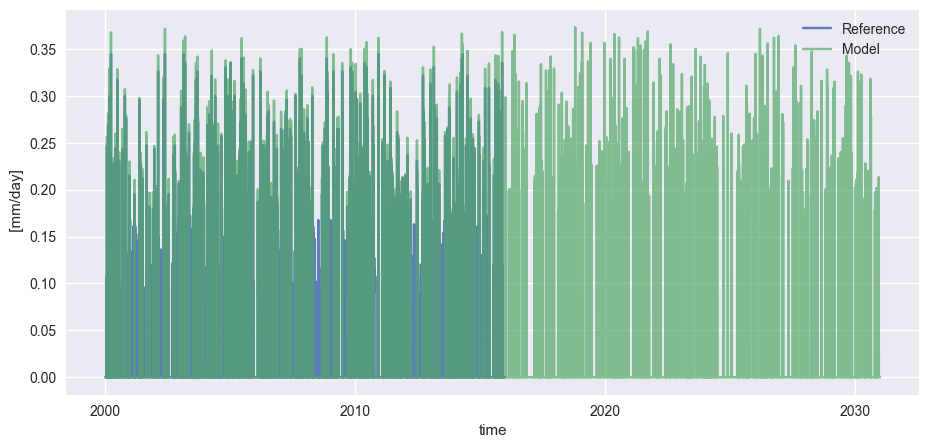

In [9]:
vals = np.random.randint(0, 1000, size=(t.size,)) / 100
vals_ref = (4 ** np.where(vals < 9, vals / 100, vals)) / 3e6
vals_sim = (
    (1 + 0.1 * np.random.random_sample((t.size,)))
    * (4 ** np.where(vals < 9.5, vals / 100, vals))
    / 3e6
)

pr_ref = xr.DataArray(
    vals_ref, coords={"time": t}, dims=("time",), attrs={"units": "mm/day"}
)
pr_ref = pr_ref.sel(time=slice("2000", "2015"))
pr_sim = xr.DataArray(
    vals_sim, coords={"time": t}, dims=("time",), attrs={"units": "mm/day"}
)
pr_hist = pr_sim.sel(time=slice("2000", "2015"))

pr_ref.plot(alpha=0.9, label="Reference")
pr_sim.plot(alpha=0.7, label="Model")
plt.legend()

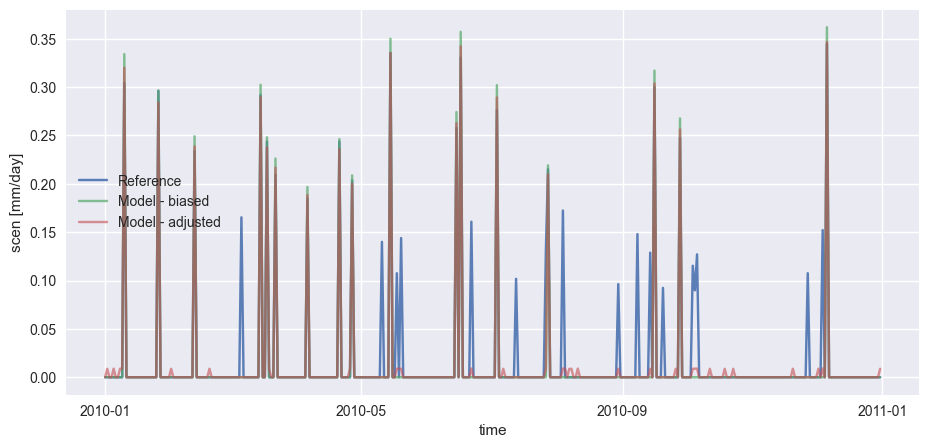

In [10]:
# 1st try without adapt_freq
QM = xsdba.EmpiricalQuantileMapping.train(
    pr_ref, pr_hist, nquantiles=15, kind="*", group="time"
)
scen = QM.adjust(pr_sim)

pr_ref.sel(time="2010").plot(alpha=0.9, label="Reference")
pr_hist.sel(time="2010").plot(alpha=0.7, label="Model - biased")
scen.sel(time="2010").plot(alpha=0.6, label="Model - adjusted")
plt.legend()

In the figure above, `scen` has small peaks where `sim` is 0. This problem originates from the fact that there are more "dry days" (days with almost no precipitation) in `hist` than in `ref`. The next example works around the problem using frequency-adaptation, as described in [Themeßl et al. (2012)](https://doi.org/10.1007/s10584-011-0224-4).

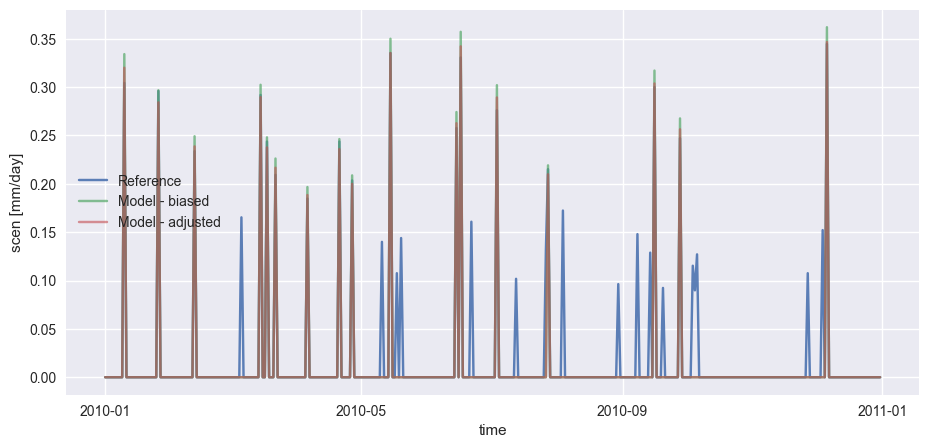

In [11]:
# 2nd try with adapt_freq
hist_ad, pth, dP0 = xsdba.processing.adapt_freq(
    pr_ref, pr_hist, thresh="0.05 mm d-1", group="time"
)
QM_ad = xsdba.EmpiricalQuantileMapping.train(
    pr_ref, hist_ad, nquantiles=15, kind="*", group="time"
)
scen_ad = QM_ad.adjust(pr_sim)

pr_ref.sel(time="2010").plot(alpha=0.9, label="Reference")
pr_sim.sel(time="2010").plot(alpha=0.7, label="Model - biased")
scen_ad.sel(time="2010").plot(alpha=0.6, label="Model - adjusted")
plt.legend()

### Second example: tas and detrending

The next example reuses the fake temperature timeseries generated at the beginning and applies the same QM adjustment method. However, for a better adjustment, we will scale sim to ref and then "detrend" the series, assuming the trend is linear. When `sim` (or `sim_scl`) is detrended, its values are now anomalies, so we need to normalize `ref` and `hist` so we can compare similar values.

This process is detailed here to show how the `xsdba` module should be used in custom adjustment processes, but this specific method also exists as `xsdba.DetrendedQuantileMapping` and is based on [Cannon et al. 2015](https://doi.org/10.1175/JCLI-D-14-00754.1). However, `DetrendedQuantileMapping` normalizes over a `time.dayofyear` group, regardless of what is passed in the  `group` argument. As done here, it is anyway recommended to use `dayofyear` groups when normalizing, especially for variables with strong seasonal variations.

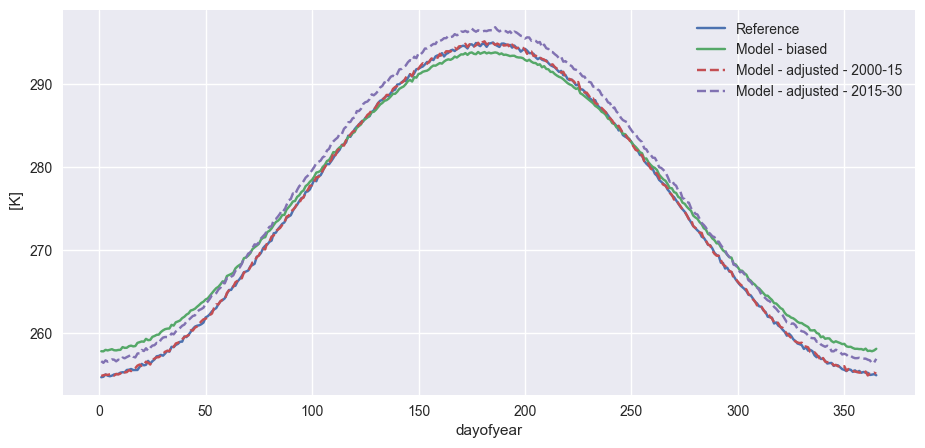

In [12]:
doy_win31 = xsdba.Grouper("time.dayofyear", window=15)
Sca = xsdba.Scaling.train(ref, hist, group=doy_win31, kind="+")
sim_scl = Sca.adjust(sim)

detrender = xsdba.detrending.PolyDetrend(degree=1, group="time.dayofyear", kind="+")
sim_fit = detrender.fit(sim_scl)
sim_detrended = sim_fit.detrend(sim_scl)

ref_n, _ = xsdba.processing.normalize(ref, group=doy_win31, kind="+")
hist_n, _ = xsdba.processing.normalize(hist, group=doy_win31, kind="+")

QM = xsdba.EmpiricalQuantileMapping.train(
    ref_n, hist_n, nquantiles=15, group="time.month", kind="+"
)
scen_detrended = QM.adjust(sim_detrended, extrapolation="constant", interp="nearest")
scen = sim_fit.retrend(scen_detrended)


ref.groupby("time.dayofyear").mean().plot(label="Reference")
sim.groupby("time.dayofyear").mean().plot(label="Model - biased")
scen.sel(time=slice("2000", "2015")).groupby("time.dayofyear").mean().plot(
    label="Model - adjusted - 2000-15", linestyle="--"
)
scen.sel(time=slice("2015", "2030")).groupby("time.dayofyear").mean().plot(
    label="Model - adjusted - 2015-30", linestyle="--"
)
plt.legend()

### Third example : Multi-method protocol - Hnilica et al. 2017
In [their paper of 2017](https://doi.org/10.1002/joc.4890), Hnilica, Hanel and Puš present a bias-adjustment method based on the principles of Principal Components Analysis.

The idea is simple: use principal components to define coordinates on the reference and on the simulation, and then transform the simulation data from the latter to the former. Spatial correlation can thus be conserved by taking different points as the dimensions of the transform space. The method was demonstrated in the article by bias-adjusting precipitation over different drainage basins.

The same method could be used for multivariate adjustment. The principle would be the same, concatenating the different variables into a single dataset along a new dimension. An example is given in the [advanced notebook](advanced_example.ipynb).

Here we show how the modularity of `xsdba` can be used to construct a quite complex adjustment protocol involving two adjustment methods : quantile mapping and principal components. Evidently, as this example uses only 2 years of data, it is not complete. It is meant to show how the adjustment functions and how the API can be used.

In [13]:
# We are using xarray's "air_temperature" dataset
ds = xr.tutorial.load_dataset("air_temperature")

In [14]:
# To get an exaggerated example we select different points
# here "lon" will be our dimension of two "spatially correlated" points
reft = ds.air.isel(lat=21, lon=[40, 52]).drop_vars(["lon", "lat"])
simt = ds.air.isel(lat=18, lon=[17, 35]).drop_vars(["lon", "lat"])

# Principal Components Adj, no grouping and use "lon" as the space dimensions
PCA = xsdba.PrincipalComponents.train(reft, simt, group="time", crd_dim="lon")
scen1 = PCA.adjust(simt)

# QM, no grouping, 20 quantiles and additive adjustment
EQM = xsdba.EmpiricalQuantileMapping.train(
    reft, scen1, group="time", nquantiles=50, kind="+"
)
scen2 = EQM.adjust(scen1)

Text(0.5, 1.0, 'Timeseries - Point 1')

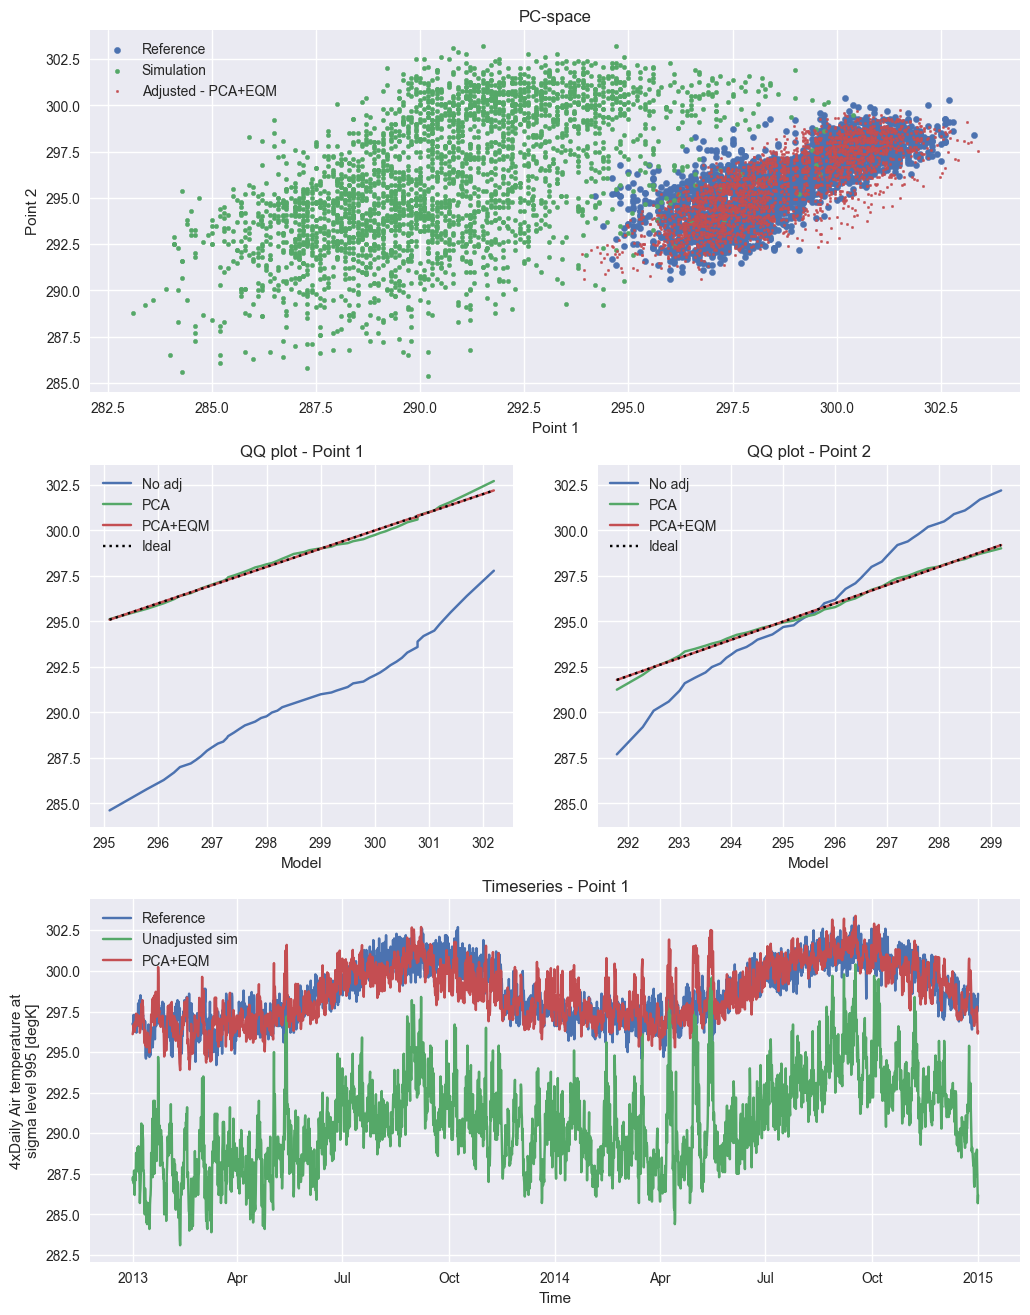

In [15]:
# some Analysis figures
fig = plt.figure(figsize=(12, 16))
gs = plt.matplotlib.gridspec.GridSpec(3, 2, fig)

axPCA = plt.subplot(gs[0, :])
axPCA.scatter(reft.isel(lon=0), reft.isel(lon=1), s=20, label="Reference")
axPCA.scatter(simt.isel(lon=0), simt.isel(lon=1), s=10, label="Simulation")
axPCA.scatter(scen2.isel(lon=0), scen2.isel(lon=1), s=3, label="Adjusted - PCA+EQM")
axPCA.set_xlabel("Point 1")
axPCA.set_ylabel("Point 2")
axPCA.set_title("PC-space")
axPCA.legend()

refQ = reft.quantile(EQM.ds.quantiles, dim="time")
simQ = simt.quantile(EQM.ds.quantiles, dim="time")
scen1Q = scen1.quantile(EQM.ds.quantiles, dim="time")
scen2Q = scen2.quantile(EQM.ds.quantiles, dim="time")

axQM = None
for i in range(2):
    if not axQM:
        axQM = plt.subplot(gs[1, 0])
    else:
        axQM = plt.subplot(gs[1, 1], sharey=axQM)
    axQM.plot(refQ.isel(lon=i), simQ.isel(lon=i), label="No adj")
    axQM.plot(refQ.isel(lon=i), scen1Q.isel(lon=i), label="PCA")
    axQM.plot(refQ.isel(lon=i), scen2Q.isel(lon=i), label="PCA+EQM")
    axQM.plot(
        refQ.isel(lon=i), refQ.isel(lon=i), color="k", linestyle=":", label="Ideal"
    )
    axQM.set_title(f"QQ plot - Point {i + 1}")
    axQM.set_xlabel("Reference")
    axQM.set_xlabel("Model")
    axQM.legend()

axT = plt.subplot(gs[2, :])
reft.isel(lon=0).plot(ax=axT, label="Reference")
simt.isel(lon=0).plot(ax=axT, label="Unadjusted sim")
# scen1.isel(lon=0).plot(ax=axT, label='PCA only')
scen2.isel(lon=0).plot(ax=axT, label="PCA+EQM")
axT.legend()
axT.set_title("Timeseries - Point 1")

### Fourth example : Multivariate bias-adjustment (Cannon, 2018)

This section replicates the "MBCn" algorithm described by [Cannon (2018)](https://doi.org/10.1007/s00382-017-3580-6). The method relies on some univariate algorithm, an adaption of the N-pdf transform of [Pitié et al. (2005)](https://ieeexplore.ieee.org/document/1544887/) and a final reordering step.

In the following, we use the Adjusted and Homogenized Canadian Climate Dataset ([AHCCD](https://open.canada.ca/data/en/dataset/9c4ebc00-3ea4-4fe0-8bf2-66cfe1cddd1d)) and CanESM2 data as reference and simulation, respectively, and correct both `pr` and `tasmax` together.

In [18]:
from xsdba.units import convert_units_to, pint_multiply
from xclim.testing import open_dataset

dref = open_dataset(
    "sdba/ahccd_1950-2013.nc", chunks={"location": 1}, drop_variables=["lat", "lon"]
).sel(time=slice("1981", "2010"))

# Fix the standard name of the `pr` variable.
# This allows the convert_units_to below to infer the correct CF transformation (precip rate to flux)
# see the "Unit handling" notebook
dref.pr.attrs["standard_name"] = "lwe_precipitation_rate"

# TODO : Do we change this example? Our datasets? Now it's a bit more complicated since `convert_units_to`
# doesn't have a `hydro` context.
dsim = open_dataset(
    "sdba/CanESM2_1950-2100.nc", chunks={"location": 1}, drop_variables=["lat", "lon"]
)
water_density_inverse = "1e-03 m^3/kg"
dsim = dsim.assign(
    tasmax=convert_units_to(dsim.tasmax, "K"),
    pr=convert_units_to(pint_multiply(dsim.pr, water_density_inverse), "mm/d")
)

dhist = dsim.sel(time=slice("1981", "2010"))
dsim = dsim.sel(time=slice("2041", "2070"))

# Stack variables : Dataset -> DataArray with `multivar` dimension
dref, dhist, dsim = (xsdba.stack_variables(da) for da in (dref, dhist, dsim))

##### Perform the multivariate adjustment (MBCn).

In [19]:
ADJ = xsdba.MBCn.train(
    dref,
    dhist,
    base_kws={"nquantiles": 20, "group": "time"},
    adj_kws={"interp": "nearest", "extrapolation": "constant"},
    n_iter=20,  # perform 20 iteration
    n_escore=1000,  # only send 1000 points to the escore metric
)

scenh, scens = (
    ADJ.adjust(
        sim=dsim,
        ref=dref,
        hist=dhist,
        base=xsdba.QuantileDeltaMapping,
        base_kws_vars={
            "pr": {
                "kind": "*",
                "jitter_under_thresh_value": "0.01 mm d-1",
                "adapt_freq_thresh": "0.1 mm d-1",
            },
            "tasmax": {"kind": "+"},
        },
        adj_kws={"interp": "nearest", "extrapolation": "constant"},
    )
    for ds in (dhist, dsim)
)

##### Let's trigger all the computations.

The use of `dask.compute` allows the three DataArrays to be computed at the same time, avoiding repeating the common steps.

In [20]:
from dask import compute
from dask.diagnostics import ProgressBar

with ProgressBar():
    scenh, scens, escores = compute(scenh, scens, ADJ.ds.escores)

[########################################] | 100% Completed | 9.13 sms


Let's compare the series and look at the distance scores to see how well the N-pdf transform has converged.

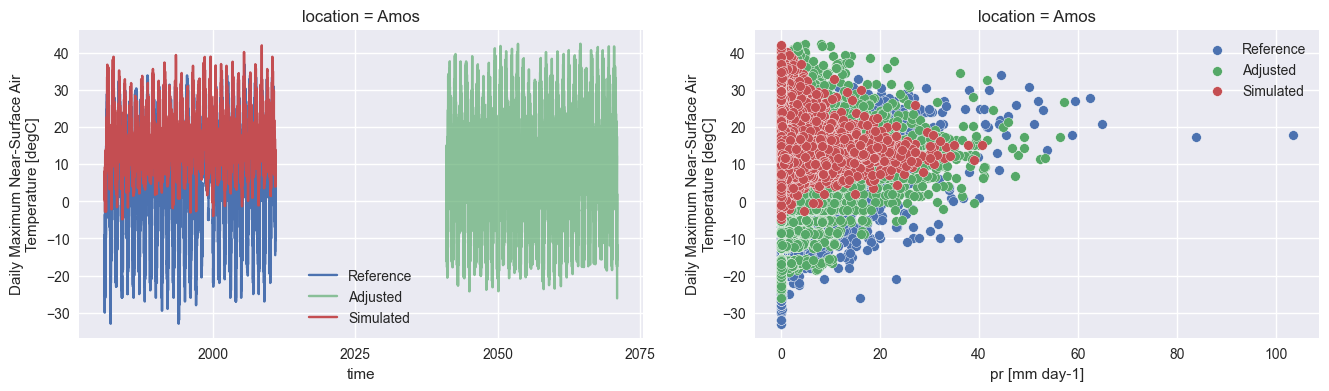

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(16, 4))
for da, label in zip((dref, scenh, dhist), ("Reference", "Adjusted", "Simulated")):
    ds = xsdba.unstack_variables(da).isel(location=2)
    # time series - tasmax
    ds.tasmax.plot(ax=axs[0], label=label, alpha=0.65 if label == "Adjusted" else 1)
    # scatter plot
    ds.plot.scatter(x="pr", y="tasmax", ax=axs[1], label=label)
axs[0].legend()
axs[1].legend()

Text(0, 0.5, 'E-score')

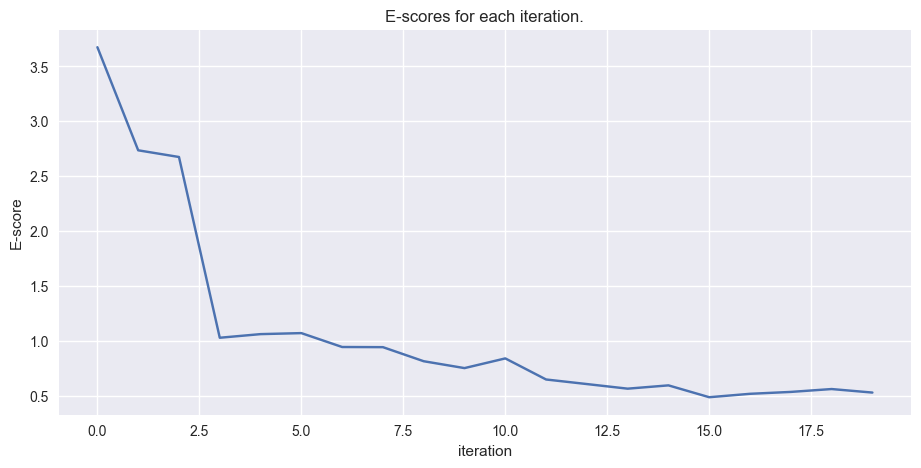

In [22]:
escores.isel(location=2).plot()
plt.title("E-scores for each iteration.")
plt.xlabel("iteration")
plt.ylabel("E-score")

The tutorial continues in the [advanced notebook](advanced_example.ipynb) with more on optimization with dask, other fancier detrending algorithms, and an example pipeline for heavy processing.
